# Моделирование КБД

### Подготовка данных

In [86]:
# устанавливаем и импортируем все необходимые библиотеки

!pip install nelson-siegel-svensson
import requests
import pandas as pd
import datetime as dt
import numpy as np
import math
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
import warnings
warnings.filterwarnings('ignore')
from sympy import symbols, Matrix
from scipy.interpolate import CubicSpline, splrep, splev
from scipy.optimize import minimize, curve_fit
from nelson_siegel_svensson import NelsonSiegelCurve, NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols

Defaulting to user installation because normal site-packages is not writeable


In [88]:
# определяем, откуда будем парсить данные

url = 'https://iss.moex.com/iss/engines/stock/markets/bonds/boards/TQOB/securities.html?date=2025-02-10'

In [90]:
# получаем данные и выполняем предобработку

req_html = requests.get(url)
df = pd.read_html(req_html.text)[0]

In [92]:
# оставляем только необходимые столбцы, фильтруем облигации

df = df[[ 'SECID (string:36)', 'PREVPRICE (double)', 'FACEVALUE (double)', 'COUPONVALUE (double)', 'COUPONPERIOD (int32)', 'MATDATE (date:10)']]
df = df[ (df['COUPONPERIOD (int32)'] == 182) & (df['FACEVALUE (double)'] == 1000.00) ]
df = df.dropna()

In [94]:
# создадим функции для обработки датафрейма

def mat_days(df):
    """ Функция приведения дат к формату datetime """
    days = dt.datetime.strptime(df['MATDATE (date:10)'], '%Y-%m-%d')
    df['MATDATE (date:10)'] = days.date()
    return df

def coup_days(df):
    """ Функция вычисления количества дней до выплат купонов """
    days = range(df['Days to maturity'], 0, -df['COUPONPERIOD (int32)'])
    df['Days to coupons'] = list(days)
    return df

def price(df):
    """ Функция вычисления рыночной цены облигации в рублях """
    price = df['FACEVALUE (double)'] * df['PREVPRICE (double)'] / 100
    df['Price'] = price
    return df

In [96]:
# вычисляем количество дней до погашения

df = df.apply(mat_days, axis=1)
df['Days to maturity']= df['MATDATE (date:10)'] - dt.date(2025, 2, 11)
df['Days to maturity'] = df['Days to maturity'].apply(lambda x: x.days)

In [98]:
# вычисляем количества дней до выплат купонов

df = df.apply(coup_days, axis=1)

In [100]:
# вычисляем рыночные цены облигаций

df = df.apply(price, axis=1)

In [102]:
# отсортируем облигации по дате погашения и сбросим индексы

df = df.sort_values('Days to maturity')
df = df.reset_index()
df = df.drop('index', axis=1)

In [104]:
# результирующий вид данных

df.head()

,SECID (string:36),PREVPRICE (double),FACEVALUE (double),COUPONVALUE (double),COUPONPERIOD (int32),MATDATE (date:10),Days to maturity,Days to coupons,Price
0,SU26234RMFS3,94.440,1000.0,22.44,182,2025-07-16,155,[155],944.40
1,SU26229RMFS3,92.542,1000.0,35.65,182,2025-11-12,274,"[274, 92]",925.42
2,SU26219RMFS4,88.243,1000.0,38.64,182,2026-09-16,582,"[582, 400, 218, 36]",882.43
3,SU26226RMFS9,88.147,1000.0,39.64,182,2026-10-07,603,"[603, 421, 239, 57]",881.47
4,SU26207RMFS9,86.416,1000.0,40.64,182,2027-02-03,722,"[722, 540, 358, 176]",864.16




---

### Cистема уравнений для процентных ставок

$\tilde{P}_1=C_1 d_{t_1}+N_1 d_{t_1},t_1=155$ \\
$\tilde{P}_2=C_2 d_{t_1}+C_2 d_{t_2}+N_2 d_{t_2},t_2=274$ \\
$\tilde{P}_3=C_3 d_{t_1}+C_3 d_{t_2}+2C_3 d_{t_3}+N_3 d_{t_3},t_3=582$ \\
$\tilde{P}_4=C_4 d_{t_1}+C_4 d_{t_2}+C_4 d_{t_3}+C_4 d_{t_4}+N_4 d_{t_4},t_4=603$ \\
$\tilde{P}_5=C_5 d_{t_2}+2C_5 d_{t_3}+C_5 d_{t_5}+N_5 d_{t_5},t_5=722$ \\
$\tilde{P}_6=C_6 d_{t_1}+C_6 d_{t_2}+2C_6 d_{t_3}+C_6 d_{t_6}+N_6 d_{t_6},t_6=750$ \\
$\tilde{P}_7=C_7 d_{t_1}+C_7 d_{t_2}+C_7 d_{t_3}+C_7 d_{t_4}+2C_7 d_{t_7}+N_7 d_{t_7},t_7=967$ \\
$\tilde{P}_8=C_8 d_{t_2}+2C_8 d_{t_3}+C_8 d_{t_5}+C_8 d_{t_7}+C_8 d_{t_8}+N_8 d_{t_8},t_8=1072$ \\
$\tilde{P}_9=C_9 d_{t_1}+2C_9 d_{t_3}+C_9 d_{t_5}+C_9 d_{t_7}+C_9 d_{t_8}+C_9 d_{t_9}+N_9 d_{t_9},t_9=1191$ \\
$\tilde{P}_{10}=C_{10} d_{t_1}+C_{10} d_{t_2}+2C_{10} d_{t_3}+2C_{10} d_{t_7}+C_{10} d_{t_9}+2C_{10} d_{t_{10}}+N_{10} d_{t_{10}},t_{10}=1492$ \\
$\tilde{P}_{11}=C_{11} d_{t_1}+2C_{11} d_{t_3}+C_{11} d_{t_5}+C_{11} d_{t_7}+C_{11} d_{t_8}+2C_{11} d_{t_{10}}+C_{11} d_{t_{11}}+N_{11} d_{t_{11}},t_{11}=1562$ \\
$\tilde{P}_{12}=C_{12} d_{t_1}+C_{12} d_{t_2}+2C_{12} d_{t_3}+C_{12} d_{t_6}+C_{12} d_{t_7}+C_{12} d_{t_9}+2C_{12} d_{t_{10}}+C_{12} d_{t_{12}}+N_{12} d_{t_{12}},t_{12}=1660$ \\
$\tilde{P}_{13}=C_{13} d_{t_1}+C_{13} d_{t_2}+C_{13} d_{t_3}+C_{13} d_{t_4}+2C_{13} d_{t_7}+C_{13} d_{t_9}+C_{13} d_{t_{10}}+C_{13} d_{t_{11}}+C_{13} d_{t_{13}}+N_{13} d_{t_{13}},t_{13}=1695$ \\
$\tilde{P}_{14}=C_{14} d_{t_1}+C_{14} d_{t_2}+C_{14} d_{t_3}+C_{14} d_{t_5}+C_{14} d_{t_7}+C_{14} d_{t_8}+C_{14} d_{t_{9}}+C_{14} d_{t_{10}}+C_{14} d_{t_{11}}+2C_{14} d_{t_{14}}+N_{14} d_{t_{14}},t_{14}=1884$ \\
$\tilde{P}_{15}=C_{15} d_{t_1}+C_{15} d_{t_2}+2C_{15} d_{t_3}+2C_{15} d_{t_7}+C_{15} d_{t_{9}}+2C_{15} d_{t_{10}}+C_{15} d_{t_{13}}+C_{15} d_{t_{14}}+2C_{15} d_{t_{15}}+N_{15} d_{t_{15}},t_{15}=2220$ \\
$\tilde{P}_{16}=C_{16} d_{t_2}+2C_{16} d_{t_3}+C_{16} d_{t_5}+C_{16} d_{t_{7}}+C_{16} d_{t_{9}}+2C_{16} d_{t_{10}}+C_{16} d_{t_{13}}+C_{16} d_{t_{14}}+2C_{16} d_{t_{15}}+C_{16} d_{t_{16}}+N_{16} d_{t_{16}},t_{16}=2353$ \\
$\tilde{P}_{17}=C_{17} d_{t_1}+C_{17} d_{t_2}+C_{17} d_{t_3}+C_{17} d_{t_4}+2C_{17} d_{t_{7}}+C_{17} d_{t_{9}}+C_{17} d_{t_{10}}+C_{17} d_{t_{11}}+C_{17} d_{t_{13}}+C_{17} d_{t_{15}}+C_{17} d_{t_{16}}+C_{17} d_{t_{17}}+N_{17} d_{t_{17}},t_{17}=2409$ \\
$\tilde{P}_{18}=C_{18} d_{t_1}+C_{18} d_{t_2}+C_{18} d_{t_3}+C_{18} d_{t_5}+C_{18} d_{t_{7}}+C_{18} d_{t_{8}}+C_{18} d_{t_{9}}+C_{18} d_{t_{10}}+C_{18} d_{t_{11}}+C_{18} d_{t_{14}}+2C_{18} d_{t_{15}}+C_{18} d_{t_{16}}+2C_{18} d_{t_{18}}+N_{18} d_{t_{18}},t_{18}=2640$ \\
$\tilde{P}_{19}=C_{19} d_{t_1}+2C_{19} d_{t_2}+C_{19} d_{t_5}+C_{19} d_{t_7}+C_{19} d_{t_{8}}+2C_{19} d_{t_{10}}+C_{19} d_{t_{11}}+C_{19} d_{t_{14}}+2C_{19} d_{t_{15}}+C_{19} d_{t_{16}}+C_{19} d_{t_{18}}+2C_{19} d_{t_{19}}+N_{19} d_{t_{19}},t_{19}=2836$ \\
$\tilde{P}_{20}=C_{20} d_{t_1}+C_{20} d_{t_2}+C_{20} d_{t_3}+C_{20} d_{t_4}+2C_{20} d_{t_{7}}+C_{20} d_{t_{9}}+C_{20} d_{t_{10}}+C_{20} d_{t_{11}}+C_{20} d_{t_{13}}+C_{20} d_{t_{14}}+C_{20} d_{t_{15}}+C_{20} d_{t_{16}}+2C_{20} d_{t_{18}}+C_{20} d_{t_{19}}+C_{20} d_{t_{20}}+N_{20} d_{t_{20}},t_{20}=2962$ \\
$\tilde{P}_{21}=C_{21} d_{t_1}+C_{21} d_{t_2}+C_{21} d_{t_3}+C_{21} d_{t_4}+2C_{21} d_{t_{7}}+C_{21} d_{t_{9}}+C_{21} d_{t_{10}}+C_{21} d_{t_{11}}+C_{21} d_{t_{13}}+C_{21} d_{t_{14}}+C_{21} d_{t_{15}}+C_{21} d_{t_{16}}+C_{21} d_{t_{17}}+C_{21} d_{t_{18}}+C_{21} d_{t_{19}}+C_{21} d_{t_{20}}+2C_{21} d_{t_{21}}+N_{21} d_{t_{21}},t_{21}=3319$ \\
$\tilde{P}_{22}=C_{22} d_{t_1}+2C_{22} d_{t_3}+C_{22} d_{t_{5}}+C_{22} d_{t_{7}}+C_{22} d_{t_{8}}+C_{22} d_{t_{9}}+C_{22} d_{t_{10}}+C_{22} d_{t_{11}}+C_{22} d_{t_{14}}+2C_{22} d_{t_{15}}+C_{22} d_{t_{18}}+2C_{22} d_{t_{19}}+2C_{22} d_{t_{21}}+C_{22} d_{t_{22}}+N_{22} d_{t_{22}},t_{22}=3375$ \\
$\tilde{P}_{23}=C_{23} d_{t_1}+2C_{23} d_{t_3}+C_{23} d_{t_5}+C_{23} d_{t_7}+C_{23} d_{t_8}+2C_{23} d_{t_{10}}+C_{23} d_{t_{12}}+C_{23} d_{t_{14}}+2C_{23} d_{t_{15}}+C_{23} d_{t_{16}}+C_{23} d_{t_{18}}+C_{23} d_{t_{19}}+C_{23} d_{t_{20}}+2C_{23} d_{t_{21}}+2C_{23} d_{t_{23}}+N_{23} d_{t_{23}},t_{23}=3585$ \\
$\tilde{P}_{24}=C_{24} d_{t_1}+2C_{24} d_{t_3}+C_{24} d_{t_5}+C_{24} d_{t_7}+C_{24} d_{t_9}+2C_{24} d_{t_{10}}+C_{24} d_{t_{12}}+C_{24} d_{t_{14}}+2C_{24} d_{t_{15}}+C_{24} d_{t_{16}}+C_{24} d_{t_{18}}+C_{24} d_{t_{19}}+C_{24} d_{t_{20}}+2C_{24} d_{t_{21}}+C_{24} d_{t_{23}}+2C_{24} d_{t_{24}}+N_{24} d_{t_{24}},t_{24}=3809$ \\
$\tilde{P}_{25}=C_{25} d_{t_1}+C_{25} d_{t_2}+C_{25} d_{t_3}+C_{25} d_{t_4}+2C_{25} d_{t_7}+C_{25} d_{t_9}+C_{25} d_{t_{10}}+C_{25} d_{t_{11}}+C_{25} d_{t_{13}}+C_{25} d_{t_{14}}+C_{25} d_{t_{15}}+C_{25} d_{t_{16}}+2C_{25} d_{t_{18}}+C_{25} d_{t_{19}}+2C_{25} d_{t_{21}}+C_{25} d_{t_{22}}+C_{25} d_{t_{23}}+C_{25} d_{t_{24}}+C_{25} d_{t_{25}}+N_{25} d_{t_{25}},t_{25}=3879$ \\
$\tilde{P}_{26}=C_{26} d_{t_1}+C_{26} d_{t_2}+2C_{26} d_{t_3}+C_{26} d_{t_6}+C_{26} d_{t_7}+C_{26} d_{t_9}+2C_{26} d_{t_{10}}+C_{26} d_{t_{12}}+C_{26} d_{t_{14}}+2C_{26} d_{t_{15}}+C_{26} d_{t_{17}}+C_{26} d_{t_{18}}+C_{26} d_{t_{19}}+C_{26} d_{t_{20}}+2C_{26} d_{t_{21}}+C_{26} d_{t_{23}}+C_{26} d_{t_{24}}+C_{26} d_{t_{25}}+C_{26} d_{t_{26}}+N_{26} d_{t_{26}},t_{26}=4012$ \\
$\tilde{P}_{27}=C_{27} d_{t_1}+C_{27} d_{t_2}+C_{27} d_{t_3}+C_{27} d_{t_4}+2C_{27} d_{t_7}+C_{27} d_{t_9}+C_{27} d_{t_{10}}+C_{27} d_{t_{11}}+C_{27} d_{t_{13}}+C_{27} d_{t_{14}}+C_{27} d_{t_{15}}+C_{27} d_{t_{16}}+C_{27} d_{t_{17}}+C_{27} d_{t_{18}}+C_{27} d_{t_{19}}+C_{27} d_{t_{20}}+2C_{27} d_{t_{21}}+C_{27} d_{t_{23}}+C_{27} d_{t_{24}}+C_{27} d_{t_{25}}+C_{27} d_{t_{27}}+N_{27} d_{t_{27}},t_{27}=4047$ \\
$\tilde{P}_{28}=C_{28} d_{t_1}+C_{28} d_{t_2}+2C_{28} d_{t_3}+C_{28} d_{t_6}+C_{28} d_{t_7}+C_{28} d_{t_9}+2C_{28} d_{t_{10}}+C_{28} d_{t_{12}}+C_{28} d_{t_{14}}+2C_{28} d_{t_{15}}+C_{28} d_{t_{17}}+C_{28} d_{t_{18}}+C_{28} d_{t_{19}}+C_{28} d_{t_{20}}+2C_{28} d_{t_{21}}+C_{28} d_{t_{23}}+C_{28} d_{t_{24}}+C_{28} d_{t_{25}}+C_{28} d_{t_{26}}+C_{28} d_{t_{28}}+N_{28} d_{t_{28}},t_{28}=4187$ \\
$\tilde{P}_{29}=C_{29} d_{t_1}+2C_{29} d_{t_3}+C_{29} d_{t_5}+C_{29} d_{t_7}+C_{29} d_{t_8}+2C_{29} d_{t_{10}}+C_{29} d_{t_{12}}+C_{29} d_{t_{14}}+2C_{29} d_{t_{15}}+C_{29} d_{t_{16}}+C_{29} d_{t_{18}}+C_{29} d_{t_{19}}+C_{29} d_{t_{20}}+2C_{29} d_{t_{21}}+2C_{29} d_{t_{23}}+C_{29} d_{t_{24}}+C_{29} d_{t_{26}}+C_{29} d_{t_{28}}+4C_{29} d_{t_{29}}+N_{29} d_{t_{29}},t_{29}=4845$ \\
$\tilde{P}_{30}=C_{30} d_{t_1}+C_{30} d_{t_2}+C_{30} d_{t_3}+C_{30} d_{t_4}+2C_{30} d_{t_7}+C_{30} d_{t_9}+C_{30} d_{t_{10}}+C_{30} d_{t_{11}}+C_{30} d_{t_{13}}+C_{30} d_{t_{14}}+C_{30} d_{t_{15}}+C_{30} d_{t_{16}}+2C_{30} d_{t_{18}}+C_{30} d_{t_{19}}+C_{30} d_{t_{20}}+C_{30} d_{t_{21}}+C_{30} d_{t_{22}}+C_{30} d_{t_{23}}+C_{30} d_{t_{24}}+C_{30} d_{t_{25}}+C_{30} d_{t_{28}}+4C_{30} d_{t_{29}}+2C_{30} d_{t_{30}}+N_{30} d_{t_{30}},t_{30}=5146$ \\
$\tilde{P}_{31}=C_{31} d_{t_1}+2C_{31} d_{t_3}+C_{31} d_{t_5}+C_{31} d_{t_7}+C_{31} d_{t_8}+2C_{31} d_{t_{10}}+C_{31} d_{t_{11}}+C_{31} d_{t_{14}}+2C_{31} d_{t_{15}}+C_{31} d_{t_{16}}+C_{31} d_{t_{18}}+2C_{31} d_{t_{19}}+2C_{31} d_{t_{21}}+C_{31} d_{t_{22}}+C_{31} d_{t_{23}}+C_{31} d_{t_{24}}+C_{31} d_{t_{26}}+C_{31} d_{t_{28}}+4C_{30} d_{t_{29}}+C_{31} d_{t_{30}}+C_{31} d_{t_{31}}+N_{31} d_{t_{31}},t_{31}=5202$ \\
$\tilde{P}_{32}=C_{32} d_{t_1}+2C_{32} d_{t_3}+C_{32} d_{t_5}+C_{32} d_{t_7}+C_{32} d_{t_8}+2C_{32} d_{t_{10}}+C_{32} d_{t_{12}}+C_{32} d_{t_{14}}+2C_{32} d_{t_{15}}+C_{32} d_{t_{16}}+C_{32} d_{t_{18}}+C_{32} d_{t_{19}}+C_{32} d_{t_{20}}+2C_{32} d_{t_{21}}+2C_{32} d_{t_{23}}+C_{32} d_{t_{24}}+C_{32} d_{t_{26}}+C_{32} d_{t_{28}}+4C_{32} d_{t_{29}}+C_{32} d_{t_{30}}+3C_{32} d_{t_{32}}+N_{32} d_{t_{32}},t_{32}=5573$ \\
$\tilde{P}_{33}=C_{33} d_{t_1}+2C_{33} d_{t_3}+C_{33} d_{t_5}+C_{33} d_{t_7}+C_{33} d_{t_8}+2C_{33} d_{t_{10}}+C_{33} d_{t_{12}}+C_{33} d_{t_{14}}+2C_{33} d_{t_{15}}+C_{33} d_{t_{16}}+C_{33} d_{t_{18}}+C_{33} d_{t_{19}}+C_{33} d_{t_{20}}+2C_{33} d_{t_{21}}+2C_{33} d_{t_{23}}+C_{33} d_{t_{24}}+C_{33} d_{t_{26}}+C_{33} d_{t_{28}}+4C_{33} d_{t_{29}}+C_{33} d_{t_{30}}+3C_{33} d_{t_{32}}+2C_{33} d_{t_{33}}+N_{33} d_{t_{33}},t_{33}=5937$ \\



---


### Bootstrap

In [173]:
# опишем функцию для автоматического составления матрицы коэффициентов для купонных выплат

def get_matrix(cdays_list, mdays, coef_list):
    """ Функция составления матрицы коэффициентов (линейных уравнений) """
    cdays = cdays_list.copy()
    cdays = cdays[::-1]
    j = 0
    for per in mdays:
        i = 0.0
        while( any(elem <= per for elem in cdays) ):
            cdays.pop(0)
            i = i + 1
        coef_list[j] = i
        j = j + 1
    return coef_list

In [111]:
# создадим список дат до погашения в днях и список рыночных цен облигаций

DaysToMaturity = df['Days to maturity'].to_list()
Prices = df['Price'].to_list()
NumPoints = len(DaysToMaturity)

In [113]:
# создадим нулевые матрицы коэффицентов для купонов и номинальных стоимостей

C_matrix = Matrix.zeros(NumPoints, NumPoints, dtype='float64')
N_matrix = Matrix.eye(NumPoints, dtype='float64')

In [115]:
# построчно заполним матрицы коэффициентов для купонов и для номинальных стоимостей

for i in range(0, NumPoints):
    listi = df['Days to coupons'].iloc[i].copy()
    C_matrix[i,:] = get_matrix(listi, DaysToMaturity, C_matrix[i,:])
    C_matrix[i,:] = C_matrix[i,:]*df['COUPONVALUE (double)'].iloc[i]
    N_matrix[i,:] = N_matrix[i,:]*df['FACEVALUE (double)'].iloc[i]

In [117]:
# матрица купонных выплат

C_matrix

Matrix([
[22.44,     0,      0,     0,     0,     0,      0,     0,     0,      0,     0,     0,     0,     0,      0,     0,     0,      0,      0,     0,      0,     0,      0,     0,     0,     0,     0,     0,      0,     0,     0,      0,    0],
[35.65, 35.65,      0,     0,     0,     0,      0,     0,     0,      0,     0,     0,     0,     0,      0,     0,     0,      0,      0,     0,      0,     0,      0,     0,     0,     0,     0,     0,      0,     0,     0,      0,    0],
[38.64, 38.64,  77.28,     0,     0,     0,      0,     0,     0,      0,     0,     0,     0,     0,      0,     0,     0,      0,      0,     0,      0,     0,      0,     0,     0,     0,     0,     0,      0,     0,     0,      0,    0],
[39.64, 39.64,  39.64, 39.64,     0,     0,      0,     0,     0,      0,     0,     0,     0,     0,      0,     0,     0,      0,      0,     0,      0,     0,      0,     0,     0,     0,     0,     0,      0,     0,     0,      0,    0],
[    0, 40.64,  81.28, 

In [119]:
# матрица основных плат

N_matrix

Matrix([
[1000.0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[     0, 1000.0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[     0,      0, 1000.0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[     0,      0,      0, 1000.0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0, 

In [121]:
# складываем матрицы и получаем результирующую матрицу коэффициентов

C_matrix = C_matrix + N_matrix

C_matrix

Matrix([
[1022.44,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,      0],
[  35.65, 1035.65,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,      0],
[  38.64,   38.64, 1077.28,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,      0],
[  39.64,   39.64,   39.64, 1039.64,       0,       0,       0,       0,       0,       0,       0,       

In [123]:
# создаем вектор значений рыночных цен облигаций

P_matrix = Matrix(Prices)

P_matrix

Matrix([
[  944.4],
[ 925.42],
[ 882.43],
[ 881.47],
[ 864.16],
[ 1016.0],
[  787.9],
[ 794.61],
[ 745.25],
[  738.9],
[ 740.01],
[ 795.21],
[1029.69],
[  737.3],
[ 638.96],
[  665.4],
[  718.0],
[ 1034.2],
[ 740.98],
[  652.0],
[  809.1],
[  609.0],
[1042.12],
[  539.5],
[  827.9],
[  597.6],
[ 826.79],
[ 566.83],
[ 699.99],
[ 572.69],
[ 822.49],
[  817.0],
[  543.0]])

In [125]:
# опишем функцию применения метода Крамера для решения системы линейных уравнений, так как матрицы большие

def cramer_rule(A, B):
    """ Функция для решения системы линейных уравнений методом Крамера """
    det_A = A.det()
    if det_A == 0:
        raise ValueError("Определитель матрицы коэффициентов равен нулю, метод Крамера не применим.")
    solutions = []
    for i in range(A.shape[0]):
        Ai = A.copy()
        Ai[:, i] = B
        solutions.append(Ai.det() / det_A)
    return solutions

In [127]:
# находим решение системы уравнений и выводим найденные значения функции дисконтирования

dtk = cramer_rule(C_matrix, P_matrix)

print("Значения функции дисконтирования:")
for i, dti in enumerate(dtk, start=1):
    print(f"dt{i}: {dti}")

Значения функции дисконтирования:
dt1: 0.923672782754978
dt2: 0.861769000429474
dt3: 0.755087377002963
dt4: 0.750994021094004
dt5: 0.737780794337855
dt6: 0.670875525615280
dt7: 0.650492174683027
dt8: 0.639944338666388
dt9: 0.601347812295349
dt10: 0.529833087091882
dt11: 0.531711058138335
dt12: 0.491399433148615
dt13: 0.427249219044352
dt14: 0.464148466107014
dt15: 0.404816639471630
dt16: 0.404206810577333
dt17: 0.365348838217767
dt18: 0.244763514582057
dt19: 0.331720484551181
dt20: 0.303400797597402
dt21: 0.263370667243435
dt22: 0.265454069387462
dt23: 0.115496450520007
dt24: 0.247247850994247
dt25: 0.220381048749020
dt26: 0.231818326167203
dt27: 0.197939774651434
dt28: 0.189235267295069
dt29: 0.176861746253344
dt30: 0.136499008242550
dt31: 0.147143105617139
dt32: 0.130854777595199
dt33: 0.135723138513451


In [128]:
# создаем нулевые векторы для значений ставок в процентах и сроков погашения в годах

rtk = Matrix.zeros(NumPoints, 1, dtype='float64')
tk = Matrix.zeros(NumPoints, 1, dtype='float64')

In [129]:
# вычисляем значения процентных ставок и сроков погашения

for i in range(NumPoints):
    tk[i] = DaysToMaturity[i] / 365
    rtk[i] = - math.log(dtk[i]) / tk[i] * 100

In [130]:
# выводим полученные значения процентных ставок

print("Значения функции срочных процентных ставок:")
for i, rti in enumerate(rtk, start=1):
    print(f"rt{i}: {rti} (%)")

Значения функции срочных процентных ставок:
rt1: 18.6968073975522 (%)
rt2: 19.8176383897057 (%)
rt3: 17.6179482705132 (%)
rt4: 17.3334195366351 (%)
rt5: 15.3739074346302 (%)
rt6: 19.4263543637339 (%)
rt7: 16.2315919277241 (%)
rt8: 15.1983711002048 (%)
rt9: 15.5862597032487 (%)
rt10: 15.5392451071741 (%)
rt11: 14.7601854839825 (%)
rt12: 15.6223951771324 (%)
rt13: 18.3121853375613 (%)
rt14: 14.8702783904015 (%)
rt15: 14.8683416937138 (%)
rt16: 14.0513152567106 (%)
rt17: 15.2561009191781 (%)
rt18: 19.4592392096587 (%)
rt19: 14.2018279695704 (%)
rt20: 14.6973569503895 (%)
rt21: 14.6725035592666 (%)
rt22: 14.3438343473174 (%)
rt23: 21.9765174487077 (%)
rt24: 13.3903349974806 (%)
rt25: 14.2311156162955 (%)
rt26: 13.2990396609012 (%)
rt27: 14.6089510498865 (%)
rt28: 14.5125136542289 (%)
rt29: 13.0510058901129 (%)
rt30: 14.1250455587279 (%)
rt31: 13.4461288970893 (%)
rt32: 13.3193702784044 (%)
rt33: 12.2781783436547 (%)


In [135]:
# сделаем запрос к ЦБ, для получения актуального значения ставки рефинансирования

soap_xml = '<?xml version="1.0" encoding="utf-8"?><soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/"><soap:Body><KeyRateXML xmlns="http://web.cbr.ru/"><fromDate>2025-02-13T00:00:00</fromDate><ToDate>2025-02-13T00:00:00</ToDate></KeyRateXML></soap:Body></soap:Envelope>'
url_xml = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx"
headers = {
    "Content-Type": "text/xml; charset=utf-8",
    "SOAPAction": "http://web.cbr.ru/KeyRateXML",
}

response = requests.post(url_xml, data=soap_xml, headers=headers)
root = et.fromstring(response.text)
KeyRate = root.find(".//KeyRate")
kr = float(KeyRate[0][1].text)

In [137]:
# преобразуем матрицы в массивы, явно приводим их к float и добавляем значение ставки рефинансирования в нулевую точку

tk = np.array(tk, dtype=float).flatten()
rtk = np.array(rtk, dtype=float).flatten()

tk = np.insert(tk, 0, 0)
rtk = np.insert(rtk, 0, kr)

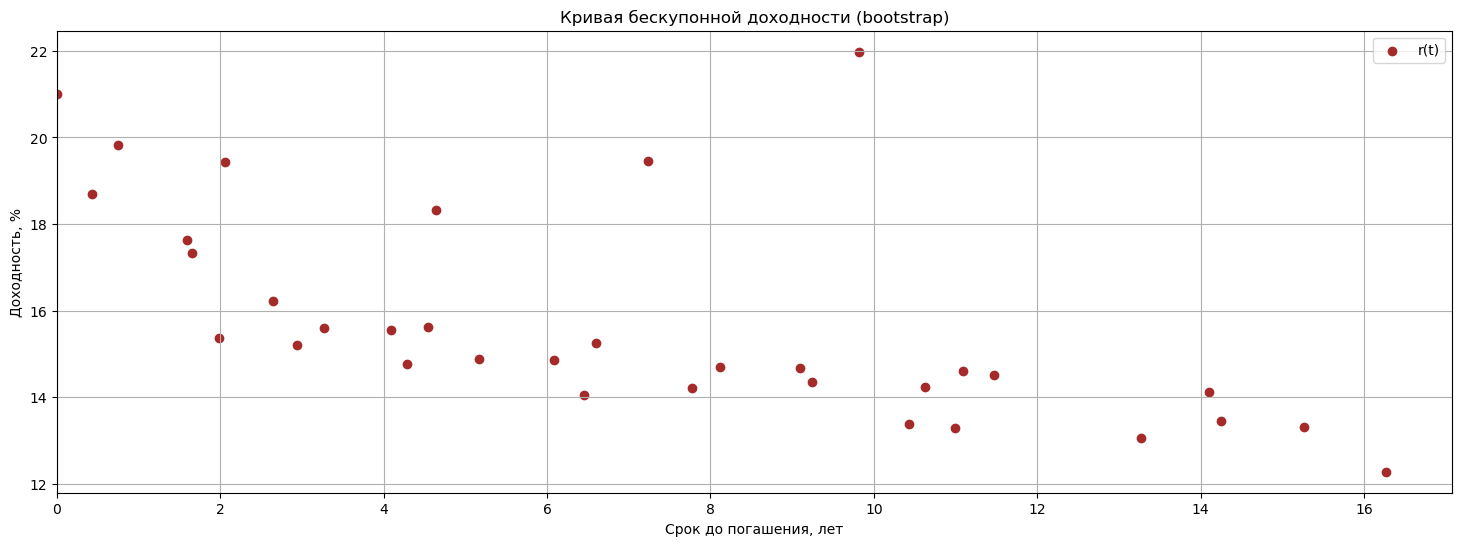

In [139]:
# строим точечный график КБД по полученным значениям

plt.figure(figsize=(18, 6))
plt.scatter(tk, rtk, color='brown', marker='o', label="r(t)")

plt.xlabel("Срок до погашения, лет")
plt.ylabel("Доходность, %")
plt.title("Кривая бескупонной доходности (bootstrap)")
plt.xlim(left=0)
plt.legend()
plt.grid()

plt.show()



---


### Сплайны

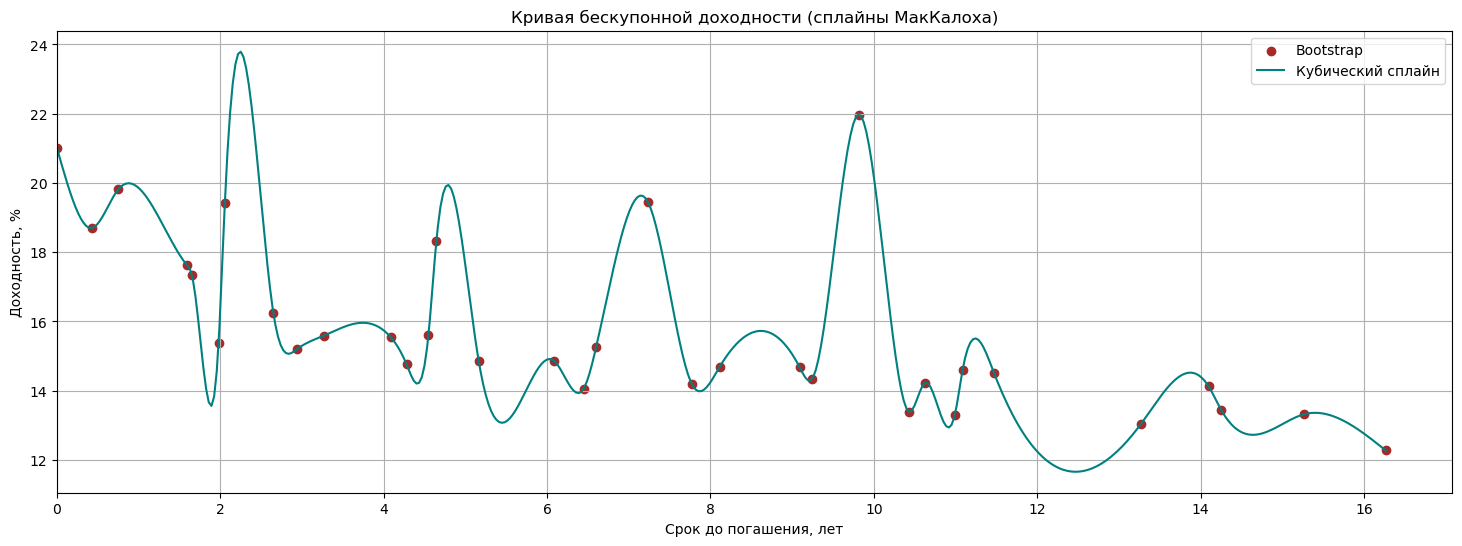

In [176]:
# создаем кубический сплайн

spline = CubicSpline(tk, rtk, bc_type='natural')  # natural — нулевые вторые производные на концах
x_smooth = np.linspace(min(tk), max(tk), 500)
y_smooth = spline(x_smooth)

# строим график КБД при помощи кубических сплайнов

plt.figure(figsize=(18, 6))
plt.scatter(tk, rtk, color='brown', label="Bootstrap")
plt.plot(x_smooth, y_smooth, label="Кубический сплайн", color='teal')

plt.xlabel("Срок до погашения, лет")
plt.ylabel("Доходность, %")
plt.title("Кривая бескупонной доходности (сплайны МакКалоха)")
plt.xlim(left=0)
plt.legend()
plt.grid()

plt.show()

In [178]:
# выберем узловые точки

node_indices = [0, 3, 7, 9, 10, 14, 19, 24, 29, 33]
node_tk = tk[node_indices]
node_rtk = rtk[node_indices]

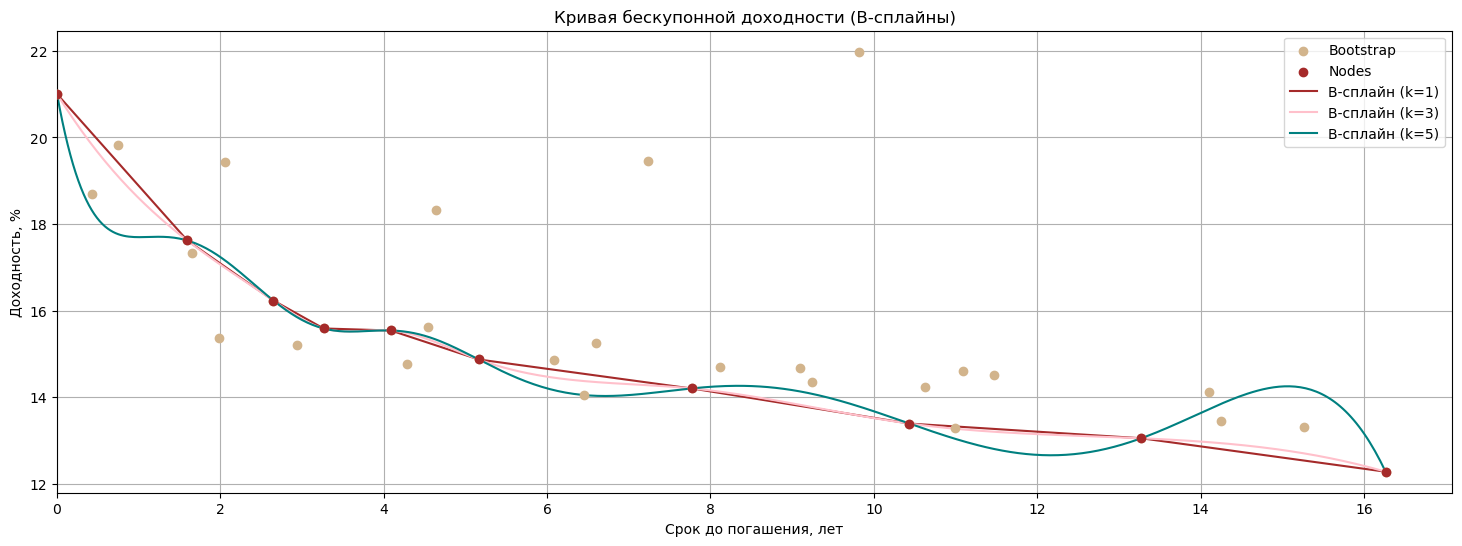

In [180]:
# построим B-сплайны различных порядков

x_smooth = np.linspace(min(node_tk), max(node_tk), 500)

colors = ['brown', 'pink', 'teal']
orders = [1, 3, 5]

plt.figure(figsize=(18, 6))
plt.scatter(tk, rtk, color='tan', label="Bootstrap", zorder=3)
plt.scatter(node_tk, node_rtk, color='brown', label="Nodes", zorder=3)

for k, color in zip(orders, colors):
    tck = splrep(node_tk, node_rtk, k=k)
    y_smooth = splev(x_smooth, tck)
    plt.plot(x_smooth, y_smooth, label=f"B-сплайн (k={k})", color=color)

plt.xlabel("Срок до погашения, лет")
plt.ylabel("Доходность, %")
plt.title("Кривая бескупонной доходности (B-сплайны)")
plt.xlim(left=0)
plt.legend()
plt.grid()

plt.show()



---


### Параметрические модели

In [149]:
# откалибруем модель Нельсона-Зигеля и выведем подобранные параметры

ns_curve, ns_status = calibrate_ns_ols(tk, rtk)

x_smooth = np.linspace(min(tk), max(tk), 200)
y_smooth = ns_curve(x_smooth)

print(f"Подобранные параметры модели Нельсона-Зигеля:")
print(f"beta0={ns_curve.beta0:.4f}, beta1={ns_curve.beta1:.4f}, beta2={ns_curve.beta2:.4f}, tau={ns_curve.tau:.4f}")

Подобранные параметры модели Нельсона-Зигеля:
beta0=13.6212, beta1=6.8429, beta2=-0.0000, tau=1.4317


In [151]:
# откалибруем модель Свенсона и выведем подобранные параметры

nss_curve, nss_status = calibrate_nss_ols(tk, rtk)

y_svensson = nss_curve(x_smooth)

print(f"Подобранные параметры модели Свенсона:")
print(f"beta0={nss_curve.beta0:.4f}, beta1={nss_curve.beta1:.4f}, beta2={nss_curve.beta2:.4f}, beta3={nss_curve.beta3:.4f}, tau1={nss_curve.tau1:.4f}, tau2={nss_curve.tau2:.4f}")

Подобранные параметры модели Свенсона:
beta0=-12.1038, beta1=33.0543, beta2=15631.5292, beta3=-15590.5391, tau1=4.5449, tau2=4.5339


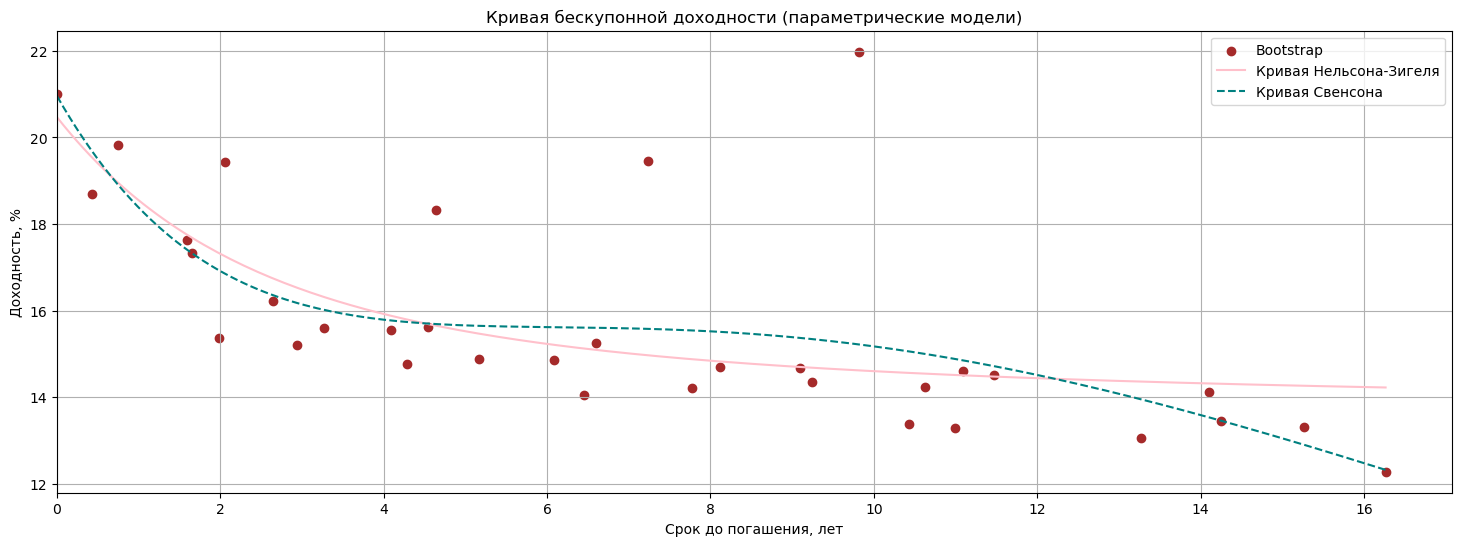

In [153]:
# построим графики КБД, полученных этими моделями

plt.figure(figsize=(18, 6))
plt.scatter(tk, rtk, color='brown', label="Bootstrap")
plt.plot(x_smooth, y_smooth, label="Кривая Нельсона-Зигеля", color='pink')
plt.plot(x_smooth, y_svensson, label="Кривая Свенсона", color='teal', linestyle='dashed')

plt.xlabel("Срок до погашения, лет")
plt.ylabel("Доходность, %")
plt.title("Кривая бескупонной доходности (параметрические модели)")
plt.xlim(left=0)
plt.legend()
plt.grid()

plt.show()

In [155]:
# опишем функцию для построения G-кривой Мосбиржи

def g_curve(t, beta0, beta1, beta2, tau1, *params):
    """ Функция для построения G-кривой """
    term1 = beta0 + (beta1 + beta2 * (t / tau1)) * np.exp(-t / tau1) - beta2 * np.exp(-t / tau1)
    g_i = params[:9]
    sigma_i = params[9:18]
    a = [0]
    a2 = 0.6
    k = 1.6
    for i in range(1, 9):
        a.append(a[i - 1] + a2 * k**(i - 1))
    correction = np.sum([g_i[i] * np.exp(-((t - a[i])**2) / sigma_i[i]**2) for i in range(9)], axis=0)
    return term1 + correction

In [157]:
# построим G-кривую и выведем подобранные параметры

initial_params = [0.01, -0.01, 0.01, 2.0] + [0.01] * 9 + [1.0] * 9

lower_bounds = [-np.inf, -np.inf, -np.inf, 0.0001] + [-1] * 9 + [0.0001] * 9
upper_bounds = [np.inf, np.inf, np.inf, 10] + [1] * 9 + [10] * 9
popt, _ = curve_fit(g_curve, tk, rtk, p0=initial_params, maxfev=20000, bounds=(lower_bounds, upper_bounds))

t_smooth = np.linspace(min(tk), max(tk), 200)
y_smooth = g_curve(t_smooth, *popt)

print("Подобранные параметры модели G-кривой:")
print(f"β0={popt[0]:.4f}, β1={popt[1]:.4f}, β2={popt[2]:.4f}, τ1={popt[3]:.4f}")
print("Корректирующие параметры:")
for i in range(9):
    print(f"g{i+1}={popt[4+i]:.4f}, σ{i+1}={popt[13+i]:.4f}")

Подобранные параметры модели G-кривой:
β0=13.5530, β1=5.6533, β2=-0.4708, τ1=5.1359
Корректирующие параметры:
g1=0.9964, σ1=1.8135
g2=0.4252, σ2=1.6330
g3=-1.0000, σ3=3.4249
g4=-1.0000, σ4=3.3544
g5=1.0000, σ5=8.2906
g6=1.0000, σ6=0.7052
g7=-1.0000, σ7=4.1604
g8=-0.9912, σ8=1.0000
g9=-0.5595, σ9=1.0000


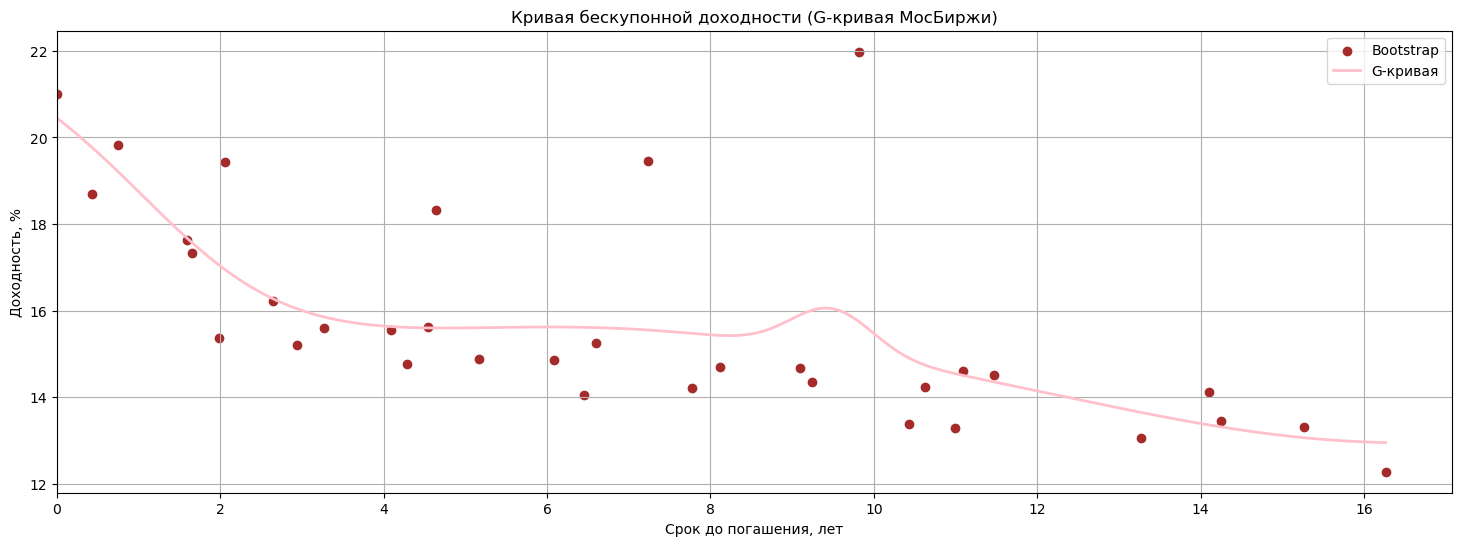

In [158]:
# построим график G-кривой

plt.figure(figsize=(18, 6))
plt.scatter(tk, rtk, color='brown', label='Bootstrap')
plt.plot(t_smooth, y_smooth, label='G-кривая', color='pink', linewidth=2)

plt.xlabel("Срок до погашения, лет")
plt.ylabel("Доходность, %")
plt.title("Кривая бескупонной доходности (G-кривая МосБиржи)")
plt.xlim(left=0)
plt.legend()
plt.grid()

plt.show()



---


### Безарбитражные модели

In [160]:
# откалибруем модель Васичека и выведем подобранные параметры

def vasicek(params, t):
    """ Функция описывающая модель Васичека """
    b, a, sigma = params
    if a <= 1e-6:
        return b + (rtk[0] - b) * np.exp(-a * t)
    return b + (rtk[0] - b) * np.exp(-a * t) + (sigma**2 / (2 * a**2)) * (1 - np.exp(-a * t)) ** 2

def objective_vasicek(params):
    """ Функция для калибровки модели Васичека """
    return np.sum((vasicek(params, tk) - rtk) ** 2)

bounds_vasicek = [(0, 1), (0, 1), (0, 1)]
opt_vasicek = minimize(objective_vasicek, [0.03, 0.15, 0.02], bounds=bounds_vasicek, method='L-BFGS-B')
vasicek_curve = vasicek(opt_vasicek.x, t_smooth)

print(f"Подобранные параметры модели Васичека:")
print(f"a={opt_vasicek.x[1]:.4f}, b={opt_vasicek.x[0]:.4f}, σ={opt_vasicek.x[2]:.4f}")

Подобранные параметры модели Васичека:
a=0.0974, b=1.0000, σ=0.5301


In [164]:
# откалибруем модель CIR и выведем подобранные параметры

def cir(params, t):
    """ Функция описывающая модель CIR """
    b, a, sigma = params
    if a <= 1e-6:
        return b + (rtk[0] - b) * np.exp(-a * t)
    return b + (rtk[0] - b) * np.exp(-a * t) + (sigma**2 / (4 * a)) * (1 - np.exp(-a * t)) ** 2

def objective_cir(params):
    """ Функция для калибровки модели CIR """
    return np.sum((cir(params, tk) - rtk) ** 2)

bounds_cir = [(0, 1), (0, 1), (0, 1)]
opt_cir = minimize(objective_cir, [0.03, 0.15, 0.02], bounds=bounds_cir, method='L-BFGS-B')
cir_curve = cir(opt_cir.x, t_smooth)

print(f"Подобранные параметры модели CIR:")
print(f"a={opt_cir.x[1]:.4f}, b={opt_cir.x[0]:.4f}, σ={opt_cir.x[2]:.4f}")

Подобранные параметры модели CIR:
a=0.0466, b=1.0000, σ=1.0000


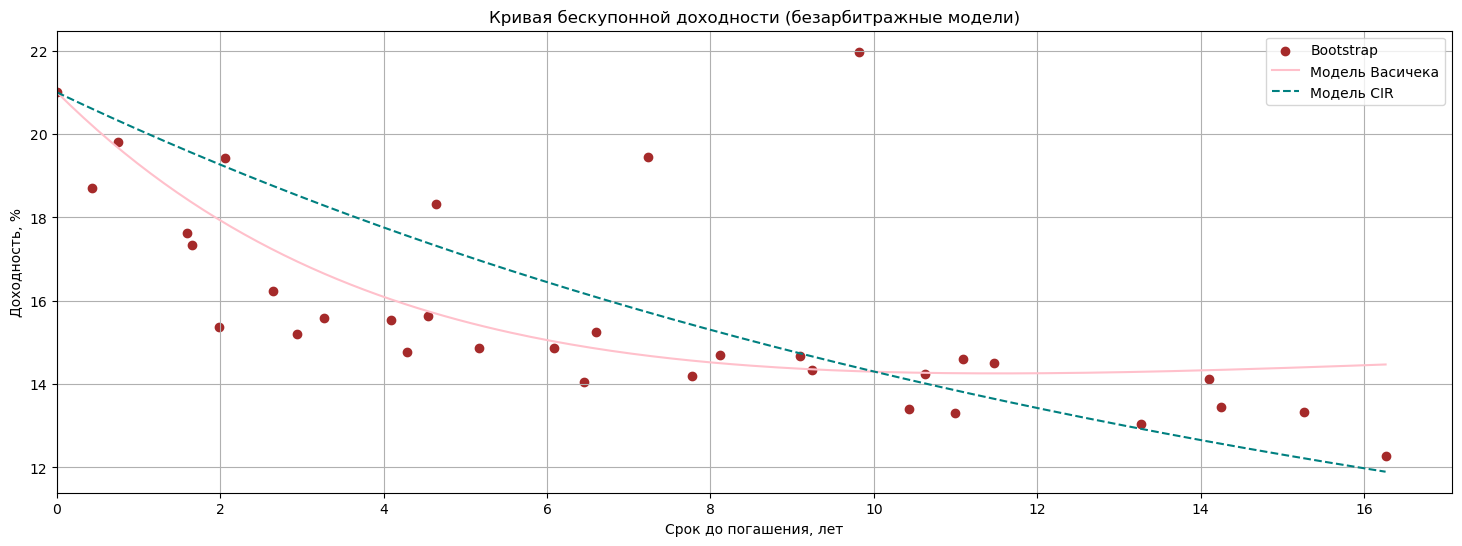

In [166]:
# построим графики КБД, полученных этими моделями

plt.figure(figsize=(18, 6))
plt.scatter(tk, rtk, color='brown', label='Bootstrap')
plt.plot(t_smooth, vasicek_curve, label='Модель Васичека', color='pink')
plt.plot(t_smooth, cir_curve, label='Модель CIR', color='teal', linestyle='dashed')

plt.xlabel("Срок до погашения, лет")
plt.ylabel("Доходность, %")
plt.title("Кривая бескупонной доходности (безарбитражные модели)")
plt.xlim(left=0)
plt.legend()
plt.grid()

plt.show()